# Tutorial 7 - Transfer Learning

**Semester:** Fall 2020

**Adapted by:** [Kevin Dick](https://kevindick.ai/)

**Adapted from:** [Transfer learning simplified example with CIFAR-10 dataset](https://github.com/tirthajyoti/Deep-learning-with-Python/blob/master/Notebooks/Transfer_learning_CIFAR.ipynb), by [Dr. Tirthajyoti Sarkar](https://tirthajyoti.github.io)

---

## What is transfer learning?

### Training Deep Learning Model is Compute-Intensive
**Deep learning networks tend to be resource hungry and computationally expensive**. Unlike traditional statistical learning models (such as regression, decision trees, or support vector machines), they tend to contain *millions of parameters* and therefore need a lot of training data to avoid overfitting.

Therefore, deep learning models are trained with **massive amounts** of **high-dimensional raw data** such as images, unstructured text, or audio signals. 

Also, they employ **millions of of vectorized computation** (e.g. matrix multiplication; **also explains why GPUs provide considerable speedup**) over and over, to optimize the huge parameter set to fit to the data. All of these lead to a great demand on the computational power needed to train and robust and high-performance deep learning model for a given task. 

Let’s say **we can afford to train a great model** after spending a huge amount of computational resources. Don’t **we want to re-use this model** for the maximum number of tasks and reap the benefit of our investment many times over?

> But, here is the problem.

**Deep learning algorithms, so far, have been traditionally designed to work in isolation**. These algorithms are trained to solve specific tasks. The models, in most cases, have to be rebuilt from scratch once the feature-space distribution changes.

> But, this does not make sense, especially if compared to how we humans utilize our limited computation speed.

**Humans have an inherent ability to transfer knowledge across tasks**. What we acquire as knowledge while learning about one task, we utilize in the same way to solve related tasks. If the similarity between the tasks or domains is high, we are able to cross-utilize our ‘learned’ knowledge better.

> ***Transfer learning is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones, as applied to machine learning, and in particular, to the domain of deep learning.***

![transfer-learning](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Transfer_learning.jpeg)

---

## Demonstrate transfer learning with a simple example
### A common strategy
There are a myriad of strategies to follow for transfer learning process in the deep learning setting, and multiple important things to consider and engineering decisions to make - similarity of datasets and domains, supervised or unsupervised setting, how much retraining to be done, etc.
However, to put it very simply, we can assume that for transfer learning, 
- we need to take a pre-trained deep learning model, 
- re-use all or certain portions of this, and 
- apply it to our new domain of interest, for a particular machine learning problem - classification or regression.

In this way, we are able to avoid a large portion of the huge computational effort of training and optimizing a large deep learning model. 

At the end, a trained deep learning model is just a collection of millions of real numbers in a particular data structure format, which can be used readily for prediction/inference, the task we are really interested in, as the consumers of the model.

But remember that a pre-trained model might have been trained using a particular classification in mind i.e. its output vector and computation graph is suited for prediction of a particular task only.

Therefore, a widely used strategy in transfer learning is to,

- load the weights matrices of a pre-trained model except for the weights of the very last layers near the O/P,
- hold those weights fixed i.e. untrainable
- attach new layers suitable for the task at hand, and train the model with new data

![TL-DL](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Transfer-learning-DL-1.png)

We demonstrate the essential concept of transfer Learning in a very simple setting.

We take the well-known CIFAR-10 dataset and do the following, 

1. Create a Keras neural net by stacking a set of `classificiation_layers` on top of a set of `feature_layers` 
2. Train this complete network on a **partial** CIFAR-10 dataset, consisting of examples from the first 5 categories (classes 0,1,2,3,4).
3. **Freeze** the `feature_layers` and **stack a new set** of fully-connected layers (Dense) on top of them, thereby creating another conv net 
4. Train this new conv net on the examples from the rest of the categories (classed 5,6,7,8,9) of CIFAR-10, tuning weights **only for those densely connected layers**




## Let's code along
### Import libraries and functions

In [1]:
from __future__ import print_function

from time import time
import keras
from keras.datasets import mnist,cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
import random

### Filters, pool size, and kernel size

In [2]:
# number of convolutional filters to use
filters = 64
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

### Load and split the data between train and test sets

In [3]:
(x_cifar_train, y_cifar_train), (x_cifar_test, y_cifar_test) = cifar10.load_data()

170500096/170498071 [==============================] - 10s 0us/step


In [4]:
y_cifar_train = y_cifar_train.reshape(50000,)
y_cifar_test = y_cifar_test.reshape(10000,)

### Create two datasets one with class labels below 5 and one with 5 and above

The plan: 
1. Train a model from scratch on the data from the first 5 classes (lt5).
2. Freeze the layeres of the model.
3. Append new (untrained) classification layers to the end.
4. Train those new layers using the data frmo the last 5 classes (gt5).

This effectively demonstrates how the **early network feature extraction layers are leveraged in a task independent of what they were originally trained for.**

In [5]:
# Dataset 1: Airplane, Automobile, Bird, Cat, Deer
x_train_lt5 = x_cifar_train[y_cifar_train < 5]
y_train_lt5 = y_cifar_train[y_cifar_train < 5]
x_test_lt5 = x_cifar_test[y_cifar_test < 5]
y_test_lt5 = y_cifar_test[y_cifar_test < 5]

# Dataset 2: Dog, Frog, Horse, Ship, Truck
x_train_gte5 = x_cifar_train[y_cifar_train >= 5]
y_train_gte5 = y_cifar_train[y_cifar_train >= 5] - 5
x_test_gte5 = x_cifar_test[y_cifar_test >= 5]
y_test_gte5 = y_cifar_test[y_cifar_test >= 5] - 5

### Let's see some examples from the two data sets to understand what's going on.

Here is the description of the categories in the CIFAR-10 dataset,

![cifar-10](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/CIFAR-10-categories.PNG)

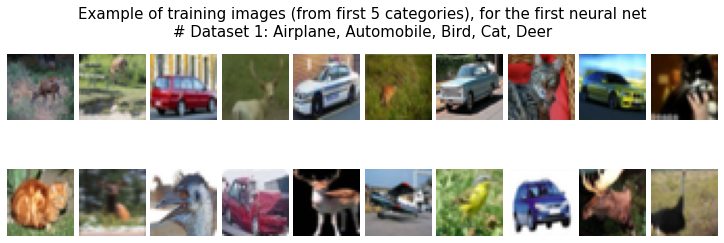

In [9]:
fig, ax = plt.subplots(2,10,figsize=(10,4))
fig.suptitle("Example of training images (from first 5 categories), for the first neural net\nDataset 1: Airplane, Automobile, Bird, Cat, Deer", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_lt5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

We can run the cell above multiple times, pick up random indices and show the images but since we are picking up images from the `x_train_lt5` dataset, we will only see images of either **airplane, automobile, bird, cat,** or **deer**.

And that's what the neural network will also 'see'.

However, when we transfer the learning to a new neural network, its output layers will be tuned on a new dataset consisting of images of either **dog, frog, horse, sheep, or truck**.

But we will see that it will do just fine :-)

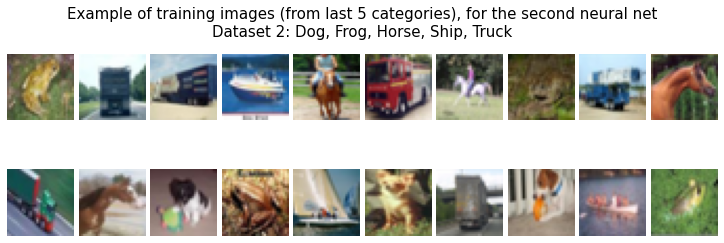

In [12]:
fig, ax = plt.subplots(2,10,figsize=(10,4))
fig.suptitle("Example of training images (from last 5 categories), for the second neural net\nDataset 2: Dog, Frog, Horse, Ship, Truck", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_gte5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

### Set the number of classes and the input shape

In [45]:
num_classes = 5
input_shape = (32,32,3) # Width, Height, RGB

### Define two groups of layers: feature (convolutions) and classification (dense)

In [46]:
# Specify Feature Extraction Layer
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

# Classification Layer
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.25),
    Dense(num_classes),
    Activation('softmax')
]

### Create the complete model by stacking together `feature_layers` and `classification_layers`

In [47]:
model_1 = Sequential(feature_layers + classification_layers)

### Function definition for training a model

In [48]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

    t1 = time() # Start a timer to demonstrate the amount of training time
    hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time()
    t_delta = round(t2-t1,2)
    print('Training time: {} seconds'.format(t_delta))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    return hist, t_delta

### Batch size and epochs

In [49]:
batch_size = 128
epochs = 20

### Train model for the first 5 categories of images

In [50]:
history1, time1 = train_model(model_1,
                     (x_train_lt5, y_train_lt5),
                     (x_test_lt5, y_test_lt5), 
                     num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Epoch 1/20
196/196 [==============================] - 2s 12ms/step - loss: 1.0352 - accuracy: 0.5752 - val_loss: 0.8047 - val_accuracy: 0.6924
Epoch 2/20
196/196 [==============================] - 2s 11ms/step - loss: 0.7761 - accuracy: 0.6961 - val_loss: 0.7335 - val_accuracy: 0.7210
Epoch 3/20
196/196 [==============================] - 2s 11ms/step - loss: 0.6744 - accuracy: 0.7420 - val_loss: 0.6695 - val_accuracy: 0.7486
Epoch 4/20
196/196 [==============================] - 2s 11ms/step - loss: 0.6156 - accuracy: 0.7672 - val_loss: 0.6738 - val_accuracy: 0.7436
Epoch 5/20
196/196 [==============================] - 2s 11ms/step - loss: 0.5447 - accuracy: 0.7903 - val_loss: 0.6032 - val_accuracy: 0.7736
Epoch 6/20
196/196 [==============================] - 2s 11ms/step - loss: 0.4883 - accuracy: 0.8157 - val_loss: 0.6961 - val_accuracy: 0.7434
Epoch 7/20
196/196 [==============================] - 2s 11ms/step - l

Also note the time taken for this training ~ 54 seconds. This will vary depending on your hardware, but keep a note of this time.

### Show the model summary and note that there are no untrainable parameters

That is, all **1,645,125** model parameters are being optimized while training!

In [51]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

### How the accuracy evolved...

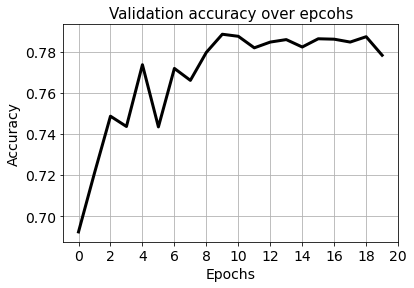

In [52]:
plt.title("Validation accuracy over epcohs",fontsize=15)
plt.plot(history1.history['val_accuracy'],lw=3,c='k')
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Freeze feature layers and rebuild model
This **freezing of feature layers is at the heart of transfer learning**. This allows **re-use of pre-trained model for classification tasks**, because users can just **stack up new fully-connected layers** on top of the pre-trained feature layers and get good performance.

We will create a fresh new model called `model_2` with the untrainable `feature_layers` and trainable `classification_layers`

In [53]:
# Set the 'trainable' parameter of each of those 
# learned feature layers to False, thereby preventing
# them from being modiified next time .fit() is called.
for l in feature_layers:
    l.trainable = False

In [54]:
# New model with the frozen feature layers from model1 and
# the classification layers are learnable
model_2 = Sequential(feature_layers + classification_layers)

### Show the model summary and see that the features layers (Conv2D) have been renderd untrainable now

In [55]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

### Now train the model and see how it takes less overall time and still gets equal or higher performance (validation accuracy)

In [56]:
# transfer: train dense layers for new classification task
history2, time2 = train_model(model_2,
                      (x_train_gte5, y_train_gte5),
                      (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Epoch 1/20
196/196 [==============================] - 1s 7ms/step - loss: 1.4576 - accuracy: 0.4905 - val_loss: 0.6975 - val_accuracy: 0.7512
Epoch 2/20
196/196 [==============================] - 1s 6ms/step - loss: 0.7090 - accuracy: 0.7392 - val_loss: 0.5377 - val_accuracy: 0.8092
Epoch 3/20
196/196 [==============================] - 1s 6ms/step - loss: 0.5708 - accuracy: 0.7904 - val_loss: 0.4805 - val_accuracy: 0.8276
Epoch 4/20
196/196 [==============================] - 1s 6ms/step - loss: 0.5026 - accuracy: 0.8136 - val_loss: 0.4628 - val_accuracy: 0.8364
Epoch 5/20
196/196 [==============================] - 1s 6ms/step - loss: 0.4373 - accuracy: 0.8406 - val_loss: 0.4323 - val_accuracy: 0.8458
Epoch 6/20
196/196 [==============================] - 1s 6ms/step - loss: 0.4014 - accuracy: 0.8520 - val_loss: 0.4212 - val_accuracy: 0.8492
Epoch 7/20
196/196 [==============================] - 1s 6ms/step - loss: 0.

The time taken has reduced significantly to ~ 25 seconds! This is because, we did not train the initial Conv2D layers and only tuned the fully connected layers. But the accuracy is pretty good.

### Plot the accuracy

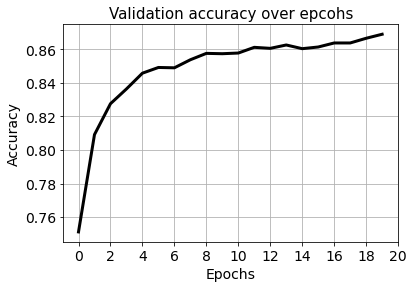

In [57]:
plt.title("Validation accuracy over epcohs",fontsize=15)
plt.plot(history2.history['val_accuracy'],lw=3,c='k')
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Time taken by the two models for training (identical number of epochs)

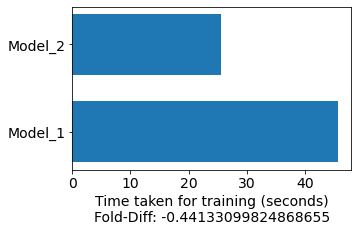

In [62]:
plt.figure(figsize=(5,3))
plt.barh(y=['Model_1','Model_2'],width=[time1,time2],height=0.7)
plt.xlabel(f"Time taken for training (seconds)\nFold-Diff: {(time2-time1)/time1}",fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

## Summary
The `model_2` was initialized a fresh model consisting of untrainable Conv2D layers and trainable fully-connected layers. The **Conv2D layers' weights were transferred** from a previously trained `model_1`.

Not only, did the `model_2` train faster than `model_1`, it also **started at a higher baseline accuracy and achieved better final accuracy for the same number of epochs** and identical hyperparameters (learning rate, optimizer, batch size, etc.).

And it achieved this training on images which were not seen by `model_1`. **This is the essence of transfer learning.**

This means that although `model_1` was trained on images of - **airplane, automobile, bird, cat, or deer** - it’s learned weights, when transferred to `model_2`, helped `model_2` achieve excellent performance on the classification of completely different categories of images - **dog, frog, horse, sheep, or truck**.

---

# Takeaway Messages
* Deep learning models are trained with **massive amounts** of **high-dimensional raw data** such as images.
* Training deep learning models requires **millions of of vectorized computations** such as matrix multiplication, repeated over and over again, to optimize the huge parameter set to fit to the data. 
* The repeated need for matrix computaation  **explains why GPUs provide considerable speedup** when training deep learning models.
* Transfer learning is the idea of **overcoming the isolated learning paradigm** and **utilizing knowledge acquired for one task to solve related ones**, as applied to machine learning, and in particular, to the domain of deep learning.
* **Transfer learnig strategy:** load the weights matrices of a **pre-trained model** *except* for the weights of the **very last layers** near the output; hold the **feature weights fixed** (i.e. untrainable/frozen); attach **new output layers** suitable for the task at hand; and **train the model with new data**.
* **Freezing of feature layers is at the heart of transfer learning**. This allows **re-use of pre-trained model for classification tasks**, because users can just **stack up new fully-connected layers** on top of the pre-trained feature layers and get good performance.
* The *Transfer Learning Models* train faster than *Trained-from-Scratch Models*, and can **start at a higher baseline accuracy and achieved better final accuracy for the same number of epochs** and identical hyperparameters (learning rate, optimizer, batch size, etc.).

